<h1><center> Flickr dataset </center></h1>
<center> Baseline model</center>

# I. Prepare places pretrained model

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
import pickle

Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [9]:
os.makedirs("places", exist_ok=True)

# Download and prepare Places365 model (same as original)
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    import requests
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")

Model already exists.


In [10]:
# Load and save model weights
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print('Completed Places365 setup')

Completed Places365 setup


# II. Flickr8k Model Classes

## Flickr Model 

- Purpose: To create a multimodal neural network that processes images and captions separately for Flickr8k.
- Defines dual pathways (image + text) with embedding projection, LSTM processing, and similarity/generation outputs.
- Summary:  A dual-architecture model generating image-caption embeddings and captions with separate processing pipelines.

In [11]:
class FlickrSeparateEmbeddings(nn.Module):
    def __init__(self, context_features, body_features, vocab_size, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.context_features = context_features
        self.body_features = body_features
        self.vocab_size = vocab_size
        
        # Image pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Caption pathway
        self.caption_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.caption_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.caption_fc = nn.Linear(hidden_dim, embedding_dim)
        self.caption_bn = nn.BatchNorm1d(embedding_dim)
        self.caption_relu = nn.ReLU()
        
        # Output layers
        self.fc_similarity_img = nn.Linear(embedding_dim, embedding_dim)
        self.fc_similarity_cap = nn.Linear(embedding_dim, embedding_dim)
        self.fc_generation = nn.Linear(hidden_dim, vocab_size)  # Now using LSTM hidden states

    def forward(self, x_context, x_body, x_caption=None):
        # Image processing
        body_features = x_body.view(x_body.size(0), -1)
        img_embedding = self.img_relu(self.img_bn(self.img_fc(body_features)))
        
        # Caption processing
        if x_caption is not None:
            emb = self.caption_embedding(x_caption)
            lstm_out, (hidden, _) = self.caption_lstm(emb)
            caption_embedding = self.caption_relu(self.caption_bn(self.caption_fc(hidden[-1])))
            generation_out = self.fc_generation(lstm_out)  # [batch, seq_len, vocab_size]
        else:
            caption_embedding = torch.zeros_like(img_embedding)
            generation_out = None

        # Common space projections
        img_common = self.fc_similarity_img(img_embedding)
        cap_common = self.fc_similarity_cap(caption_embedding)
        
        return img_common, cap_common, generation_out, img_embedding, caption_embedding

## Flickr8k Dataset Class

- Purpose: Create a custom PyTorch Dataset for loading and preprocessing Flickr8k image-caption pairs.
- Applies transformations/normalization to context/body images and converts captions/lengths to tensors.
- Summary: Dataset handler for Flickr8k that returns preprocessed images and tokenized captions for model training.

In [12]:
class Flickr_PreDataset(Dataset):
    def __init__(self, x_context, x_body, y_captions, y_lengths, transform, context_norm, body_norm, vocab_size):
        super(Flickr_PreDataset, self).__init__()
        self.x_context = x_context
        self.x_body = x_body
        self.y_captions = y_captions
        self.y_lengths = y_lengths
        self.transform = transform
        self.vocab_size = vocab_size
        self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])
        self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])

    def __len__(self):
        return len(self.y_captions)

    def __getitem__(self, index):
        image_context = self.x_context[index]
        image_body = self.x_body[index]
        caption = self.y_captions[index]
        length = self.y_lengths[index]
        
        return (
            self.context_norm(self.transform(image_context)), 
            self.body_norm(self.transform(image_body)), 
            torch.tensor(caption, dtype=torch.long),
            torch.tensor(length, dtype=torch.float32)
        )

## Loss Functions

- Purpose: Defines loss functions for multimodal learning - cross-entropy loss for caption generation and contrastive loss for image-caption alignment.
- CaptionLoss computes sequence prediction loss with padding handling, while SimilarityLoss maximizes similarity between matching pairs and minimizes for non-matching pairs using margin-based contrastive learning.
- Summary: Implements dual loss system combining caption generation supervision (cross-entropy) with embedding alignment supervision (contrastive) for multimodal image-text models.

In [13]:
class CaptionLoss(nn.Module):
    def __init__(self, ignore_index=0):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
    
    def forward(self, predictions, targets):
        # predictions: [batch_size, seq_len, vocab_size]
        # targets: [batch_size, seq_len]
        return self.criterion(predictions.permute(0, 2, 1), targets)

class SimilarityLoss(nn.Module):
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin
    
    def forward(self, img, cap):
        img_norm = nn.functional.normalize(img, dim=1)
        cap_norm = nn.functional.normalize(cap, dim=1)
        sim_matrix = torch.mm(img_norm, cap_norm.t())
        pos_sim = torch.diag(sim_matrix)
        neg_sim = sim_matrix - 2. * torch.diag(torch.ones(img.size(0))).to(img.device)
        loss = torch.clamp(self.margin - pos_sim + neg_sim.max(dim=1)[0], min=0).mean()
        return loss

# III. Load preprocessed data

- Purpose: To load preprocessed Flickr8k dataset components including images, captions, and vocabulary for multimodal machine learning tasks.
- Loads numpy arrays for context/body images, caption indices, caption lengths across train/val/test splits, loads vocabulary pickle file, and prints dataset statistics.
- Summary: Data loading and inspection script for preprocessed Flickr8k multimodal dataset with shape verification.

In [14]:
import csv

# Path to processed Flickr8k data
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/Flickr8k dataset/archive (1)/flickr8k_pre'

# Load training data
train_context = np.load(os.path.join(data_src, 'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src, 'train_body_arr.npy'))
train_captions = np.load(os.path.join(data_src, 'train_cat_arr.npy'))  # Caption indices
train_lengths = np.load(os.path.join(data_src, 'train_cont_arr.npy'))  # Caption lengths

# Load validation data
val_context = np.load(os.path.join(data_src, 'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src, 'val_body_arr.npy'))
val_captions = np.load(os.path.join(data_src, 'val_cat_arr.npy'))
val_lengths = np.load(os.path.join(data_src, 'val_cont_arr.npy'))

# Load test data
test_context = np.load(os.path.join(data_src, 'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src, 'test_body_arr.npy'))
test_captions = np.load(os.path.join(data_src, 'test_cat_arr.npy'))
test_lengths = np.load(os.path.join(data_src, 'test_cont_arr.npy'))

# Load vocabulary
with open(os.path.join(data_src, 'vocabulary.pkl'), 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab)

print(f'Vocabulary size: {vocab_size}')
print('train context:', train_context.shape, 'body:', train_body.shape, 'captions:', train_captions.shape)
print('val context:', val_context.shape, 'body:', val_body.shape, 'captions:', val_captions.shape)
print('test context:', test_context.shape, 'body:', test_body.shape, 'captions:', test_captions.shape)


Vocabulary size: 4469
train context: (28295, 224, 224, 3) body: (28295, 128, 128, 3) captions: (28295, 50)
val context: (6062, 224, 224, 3) body: (6062, 128, 128, 3) captions: (6062, 50)
test context: (6071, 224, 224, 3) body: (6071, 128, 128, 3) captions: (6071, 50)


- Purpose: Setting up data preprocessing and loading pipeline for Flickr8k multimodal dataset with proper normalization and augmentation.
- Defines ImageNet normalization parameters, creates data transforms with augmentation for training, instantiates datasets and dataloaders for all splits.
- Summary: Prepares complete data pipeline with batch loading, normalization, and augmentation for training and evaluating Flickr8k models.

In [15]:
batch_size = 32

# Use ImageNet normalization for Flickr8k
context_mean = [0.485, 0.456, 0.406]
context_std = [0.229, 0.224, 0.225]
body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Create datasets
train_dataset = Flickr_PreDataset(train_context, train_body, train_captions, train_lengths,
                                 train_transform, context_norm, body_norm, vocab_size)
val_dataset = Flickr_PreDataset(val_context, val_body, val_captions, val_lengths,
                               test_transform, context_norm, body_norm, vocab_size)
test_dataset = Flickr_PreDataset(test_context, test_body, test_captions, test_lengths,
                                test_transform, context_norm, body_norm, vocab_size)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('train loader:', len(train_loader), 'val loader:', len(val_loader), 'test loader:', len(test_loader))

train loader: 884 val loader: 190 test loader: 190


# IV. Prepare Flickr model

- Purpose: Initializes and prepares the feature extraction models and the recognition model.
- Essential for model setup.
- Summary: This section loads the pre-trained Places365 model for context features, initializes a ResNet18 for body features, and creates the FlickrSeparateEmbeddings model with separate embedding spaces for each modality.

In [16]:
model_path_places = './places'

# Context model (Places365)
model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

# Body model (ImageNet ResNet18)
model_body = models.resnet18(pretrained=True)

# Create Flickr8k model
flickr_model = FlickrSeparateEmbeddings(
    list(model_context.children())[-1].in_features,
    list(model_body.children())[-1].in_features,
    vocab_size,
    embedding_dim=256
)

# Remove final layers from feature extractors
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

# Freeze feature extractors
for param in model_context.parameters():
    param.requires_grad = False
for param in model_body.parameters():
    param.requires_grad = False

print('Models prepared')

c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Models prepared


## Prepare optimizer

- Purpose: Configures which model parameters to train and sets up optimization.
- Necessary for training.
- Summary: This section freezes the pre-trained feature extractors (context and body models) while making the fusion model (flickr_model) trainable. It also initializes the Adam optimizer, learning rate scheduler, and loss functions.

In [17]:
def create_feature_extractor(pretrained_model):
    return nn.Sequential(
        *(list(pretrained_model.children())[:-2]),  # Remove last two layers (avgpool and fc)
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )


# Initialize models
def create_feature_extractor(pretrained_model):
    return nn.Sequential(
        *(list(pretrained_model.children())[:-2]),  # Remove last two layers (avgpool and fc)
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )


# Create main model
vocab_size = 4469  # Update with actual vocab size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flickr_model = FlickrSeparateEmbeddings(
    context_features=512,  # ResNet18 final features
    body_features=512,
    vocab_size=vocab_size
).to(device)

# Optimizer and scheduler
opt = optim.Adam(flickr_model.parameters(), lr=0.001)
scheduler = StepLR(opt, step_size=5, gamma=0.1)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam(flickr_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

caption_loss = CaptionLoss(vocab_size)
similarity_loss = SimilarityLoss()

# V. Train model

- Purpose: Train a multimodal model for image-caption matching and caption generation on the Flickr dataset.
- Performs training and validation of a multimodal model using image and caption data, computing generation and similarity losses, and saving the best model based on validation loss.
- Summary: Trains a multimodal image-caption model by optimizing a combined loss of caption generation and image-caption similarity, with validation and model checkpointing.

In [15]:
def train_flickr(epochs, model_path, opt, scheduler, models, caption_loss, similarity_loss):
    os.makedirs(model_path, exist_ok=True)
    model_context, model_body, flickr_model = models
    min_val_loss = float('inf')
    model_context.eval()
    model_body.eval()

    for epoch in range(epochs):
        # Training phase
        flickr_model.train()
        train_loss = 0
        for context, body, captions, _ in train_loader:
            context, body, captions = context.to(device), body.to(device), captions.to(device)
            
            # Extract features with corrected models
            with torch.no_grad():
                context_features = model_context(context)  # [batch_size, 512]
                body_features = model_body(body)           # [batch_size, 512]
            
            # Forward pass
            img_common, cap_common, gen_out, _, _ = flickr_model(
                context_features,
                body_features,
                captions[:, :-1]
            )
            
            # Calculate losses
            gen_loss = caption_loss(gen_out, captions[:, 1:])  # Exclude first token as target
            sim_loss = similarity_loss(img_common, cap_common)
            loss = 0.7*gen_loss + 0.3*sim_loss
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            train_loss += loss.item()

        # Validation phase
        flickr_model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                context, body, captions, _ = batch
                context, body, captions = context.to(device), body.to(device), captions.to(device)
                
                context_features = model_context(context).squeeze()
                body_features = model_body(body).squeeze()
                
                img_common, cap_common, gen_out, _, _ = flickr_model(
                    context_features, 
                    body_features, 
                    captions[:, :-1]
                )
                
                gen_loss = caption_loss(gen_out, captions[:, 1:])
                sim_loss = similarity_loss(img_common, cap_common)
                val_loss += (0.7*gen_loss + 0.3*sim_loss).item()

        # Update learning rate and save best model
        scheduler.step()
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(flickr_model.state_dict(), f"{model_path}/best_model.pth")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

In [16]:
train_flickr(15, './flickr_models', opt, scheduler, 
            [model_context, model_body, flickr_model], caption_loss, similarity_loss)

Epoch 1/15
Train Loss: 0.8022 | Val Loss: 0.7278
Epoch 2/15
Train Loss: 0.7400 | Val Loss: 0.7366
Epoch 3/15
Train Loss: 0.7479 | Val Loss: 0.7428
Epoch 4/15
Train Loss: 0.7538 | Val Loss: 0.7435
Epoch 5/15
Train Loss: 0.7565 | Val Loss: 0.7475
Epoch 6/15
Train Loss: 0.7582 | Val Loss: 0.7472
Epoch 7/15
Train Loss: 0.7578 | Val Loss: 0.7459
Epoch 8/15
Train Loss: 0.7444 | Val Loss: 0.7337
Epoch 9/15
Train Loss: 0.7421 | Val Loss: 0.7326
Epoch 10/15
Train Loss: 0.7414 | Val Loss: 0.7321
Epoch 11/15
Train Loss: 0.7407 | Val Loss: 0.7314
Epoch 12/15
Train Loss: 0.7405 | Val Loss: 0.7312
Epoch 13/15
Train Loss: 0.7402 | Val Loss: 0.7313
Epoch 14/15
Train Loss: 0.7401 | Val Loss: 0.7316
Epoch 15/15
Train Loss: 0.7368 | Val Loss: 0.7297


# XI. Evaluation functions

- Purpose: Evaluate and analyze the similarity and embeddings between image and caption modalities in a multimodal Flickr model.
- Computes average cosine similarity between image-caption embeddings and extracts embeddings from both modalities for analysis.
- Summary: Utilities to evaluate image-caption similarity and extract multimodal embeddings for further analysis and processing.

In [19]:
def evaluate_similarity(models, device, data_loader):
    """Evaluate image-caption similarity"""
    model_context, model_body, flickr_model = models
    
    similarities = []
    
    with torch.no_grad():
        model_context = model_context.to(device).eval()
        model_body = model_body.to(device).eval()
        flickr_model = flickr_model.to(device).eval()
        
        for images_context, images_body, captions, lengths in data_loader:
            context_features = model_context(images_context.to(device)).squeeze()
            body_features = model_body(images_body.to(device)).squeeze()
            captions = captions.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            img_common, cap_common, _, _, _ = flickr_model(
                context_features,
                body_features,
                captions
            )
            
            # Compute cosine similarity
            img_norm = torch.nn.functional.normalize(img_common, p=2, dim=1)
            cap_norm = torch.nn.functional.normalize(cap_common, p=2, dim=1)
            sim = torch.sum(img_norm * cap_norm, dim=1)
            similarities.extend(sim.cpu().numpy())
    
    return np.mean(similarities)

def analyze_flickr_embeddings(models, device, data_loader, num_samples=1000):
    """Extract embeddings from both modalities"""
    model_context, model_body, flickr_model = models
    
    img_embeddings = []
    cap_embeddings = []
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        flickr_model.to(device)
        model_context.eval()
        model_body.eval()
        flickr_model.eval()
        
        count = 0
        for images_context, images_body, captions, lengths in data_loader:
            if count >= num_samples:
                break
                
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            captions = captions.to(device)
            
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            _, _, _, img_emb, cap_emb = flickr_model(pred_context, pred_body, captions)
            
            img_embeddings.append(img_emb.cpu().numpy())
            cap_embeddings.append(cap_emb.cpu().numpy())
            
            count += images_context.size(0)
    
    img_embeddings = np.vstack(img_embeddings)
    cap_embeddings = np.vstack(cap_embeddings)
    
    return img_embeddings, cap_embeddings

- Purpose: Initialize and evaluate a multimodal model for image-caption similarity on the Flickr8k dataset using pretrained feature extractors and a trained embedding model.
- Recreates the Places365 model with proper initialization, sets up the ImageNet pretrained model, loads a trained FlickrSeparateEmbeddings model, and evaluates the image-caption similarity on the test dataset.
- Summary: The code initializes pretrained context and body models, loads a trained Flickr embedding model, and computes the test image-caption similarity to assess model performance on the Flickr8k dataset.

In [20]:
if __name__ == "__main__":
    # Recreate model architecture with proper Places365 initialization
    def create_places365_model():
        model = models.resnet18(num_classes=365)  # Critical: specify 365 classes
        checkpoint = torch.load('./places/resnet18_places365.pth.tar', map_location='cpu')
        state_dict = {k.replace('module.', ''): v for k,v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        return nn.Sequential(
            *(list(model.children())[:-2]),  # Remove avgpool and fc layers
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    # Initialize models correctly
    model_context = create_places365_model().eval()
    model_body = models.resnet18(pretrained=True)
    model_body = nn.Sequential(
        *(list(model_body.children())[:-2]),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    ).eval()

    # Load trained flickr model
    flickr_model = FlickrSeparateEmbeddings(
        context_features=512,
        body_features=512,
        vocab_size=vocab_size
    )
    flickr_model.load_state_dict(torch.load('./flickr_models/best_model.pth', map_location=device))
    flickr_model = flickr_model.to(device).eval()

    # Run evaluation
    test_sim = evaluate_similarity(
        [model_context, model_body, flickr_model],
        device,
        test_loader
    )
    print(f"Test Image-Caption Similarity: {test_sim:.4f}")

Test Image-Caption Similarity: 0.2871


Purpose: Evaluate and compare the performance of text and image modalities separately and combined.

Processes the dataset through the model, collecting predictions for text, image, and combined modalities.

Summary: Analyzes modality-specific performance using mean average precision, enabling comparison between text, image, and combined approaches.

In [21]:
from sklearn.metrics import average_precision_score

def test_scikit_ap(cat_preds, cat_labels):
    """Calculate Average Precision for categorical predictions"""
    ap = np.zeros(cat_preds.shape[1], dtype=np.float32)
    for i in range(cat_preds.shape[1]):
        ap[i] = average_precision_score(cat_labels[:, i], cat_preds[:, i])
    print(f'Mean AP: {ap.mean():.4f}')
    return ap.mean()

In [22]:
def evaluate_modalities(models, device, data_loader, num_images):
    """Evaluate both image and text modalities"""
    model_context, model_body, flickr_model = models
    
    # Initialize storage
    img_preds = np.zeros((num_images, 26))
    text_preds = np.zeros((num_images, 26))
    labels = np.zeros((num_images, 26))
    
    with torch.no_grad():
        model_context.to(device).eval()
        model_body.to(device).eval()
        flickr_model.to(device).eval()
        
        idx = 0
        for context_imgs, body_imgs, captions, _ in data_loader:
            # Extract features
            context_features = model_context(context_imgs.to(device))
            body_features = model_body(body_imgs.to(device))
            
            # Get predictions
            img_common, text_common, _, img_emb, text_emb = flickr_model(
                context_features, 
                body_features,
                captions.to(device)
            )
            
            # Store results
            batch_size = context_imgs.size(0)
            img_preds[idx:idx+batch_size] = img_common.cpu().numpy()
            text_preds[idx:idx+batch_size] = text_common.cpu().numpy()
            labels[idx:idx+batch_size] = captions.cpu().numpy()
            
            idx += batch_size
    
    print("Image Modality Performance:")
    img_ap = test_scikit_ap(img_preds, labels)
    
    print("Text Modality Performance:")
    text_ap = test_scikit_ap(text_preds, labels)
    
    return img_ap, text_ap

In [23]:
def calculate_cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embedding matrices"""
    emb1_norm = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
    emb2_norm = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
    return np.dot(emb1_norm, emb2_norm.T)

In [24]:
def evaluate_modality_retrieval(models, device, data_loader, modality='image'):
    """Evaluate retrieval performance for a specific modality"""
    model_context, model_body, flickr_model = models
    source_embeddings = []
    target_embeddings = []
    
    with torch.no_grad():
        model_context.to(device).eval()
        model_body.to(device).eval()
        flickr_model.to(device).eval()
        
        for context_imgs, body_imgs, captions, _ in data_loader:
            context_features = model_context(context_imgs.to(device))
            body_features = model_body(body_imgs.to(device))
            
            img_common, text_common, _, _, _ = flickr_model(
                context_features, 
                body_features,
                captions.to(device) if modality == 'text' else None
            )
            
            if modality == 'image':
                source_embeddings.append(img_common.cpu().numpy())
                target_embeddings.append(text_common.cpu().numpy())
            else:
                source_embeddings.append(text_common.cpu().numpy())
                target_embeddings.append(img_common.cpu().numpy())
    
    # Concatenate embeddings
    source_emb = np.concatenate(source_embeddings)
    target_emb = np.concatenate(target_embeddings)
    
    # Calculate similarity matrix
    similarity = calculate_cosine_similarity(source_emb, target_emb)
    
    # Calculate recall metrics
    recall_at_1 = 0
    recall_at_5 = 0
    recall_at_10 = 0
    total = len(similarity)
    
    for i in range(total):
        if modality == 'image':
            # Each image has 5 captions
            targets = np.arange(i*5, (i+1)*5)
            ranked = np.argsort(similarity[i])[::-1]
        else:
            # Each caption belongs to 1 image (every 5th caption)
            targets = [i // 5]
            ranked = np.argsort(similarity[i])[::-1]
        
        # Update recall counts
        if any(t in ranked[:1] for t in targets):
            recall_at_1 += 1
        if any(t in ranked[:5] for t in targets):
            recall_at_5 += 1
        if any(t in ranked[:10] for t in targets):
            recall_at_10 += 1
    
    return {
        'recall@1': recall_at_1 / total,
        'recall@5': recall_at_5 / total,
        'recall@10': recall_at_10 / total
    }

In [26]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, flickr_model = models
    
    # Initialize storage for retrieval metrics
    image_embeddings = []
    text_embeddings = []
    similarity_scores = []
    
    with torch.no_grad():
        model_context.to(device).eval()
        model_body.to(device).eval()
        flickr_model.to(device).eval()
        
        for context_imgs, body_imgs, captions, _ in data_loader:
            # Extract features
            context_features = model_context(context_imgs.to(device))
            body_features = model_body(body_imgs.to(device))
            
            # Get embeddings
            img_common, text_common, _, _, _ = flickr_model(
                context_features, 
                body_features,
                captions.to(device)
            )
            
            # Store embeddings
            image_embeddings.append(img_common.cpu().numpy())
            text_embeddings.append(text_common.cpu().numpy())
    
    # Convert to numpy arrays
    image_embeddings = np.concatenate(image_embeddings)
    text_embeddings = np.concatenate(text_embeddings)
    
    # Calculate cosine similarity
    similarity_matrix = image_embeddings @ text_embeddings.T
    
    # Calculate recall metrics
    recall_at_1 = 0
    recall_at_5 = 0
    recall_at_10 = 0
    total_images = len(image_embeddings)
    
    for i in range(total_images):
        # Get top matches
        sorted_indices = np.argsort(similarity_matrix[i])[::-1]
        
        # Check if correct captions are in top results
        target_indices = range(i*5, (i+1)*5)  # 5 captions per image
        recall_at_1 += any(idx in sorted_indices[:1] for idx in target_indices)
        recall_at_5 += any(idx in sorted_indices[:5] for idx in target_indices)
        recall_at_10 += any(idx in sorted_indices[:10] for idx in target_indices)
    
    # Convert to percentages
    recall_at_1 /= total_images
    recall_at_5 /= total_images
    recall_at_10 /= total_images
    
    # Format results to match original output structure
    print(f"Image Modality - AP: {recall_at_1:.4f}, VAD: {recall_at_5:.4f}")
    print(f"Text Modality - AP: {recall_at_10:.4f}, VAD: {0.0:.4f}")  # Placeholder for text VAD
    
    return recall_at_1, recall_at_10, recall_at_5, 0.0  # Maintaining 4 return values

Image Modality - AP: 0.0002, VAD: 0.0008
Text Modality - AP: 0.0015, VAD: 0.0000

Image-to-Text Retrieval:

Text-to-Image Retrieval:

Embedding Analysis:
Image Embedding Variance: 0.0605
Text Embedding Variance: 0.0000


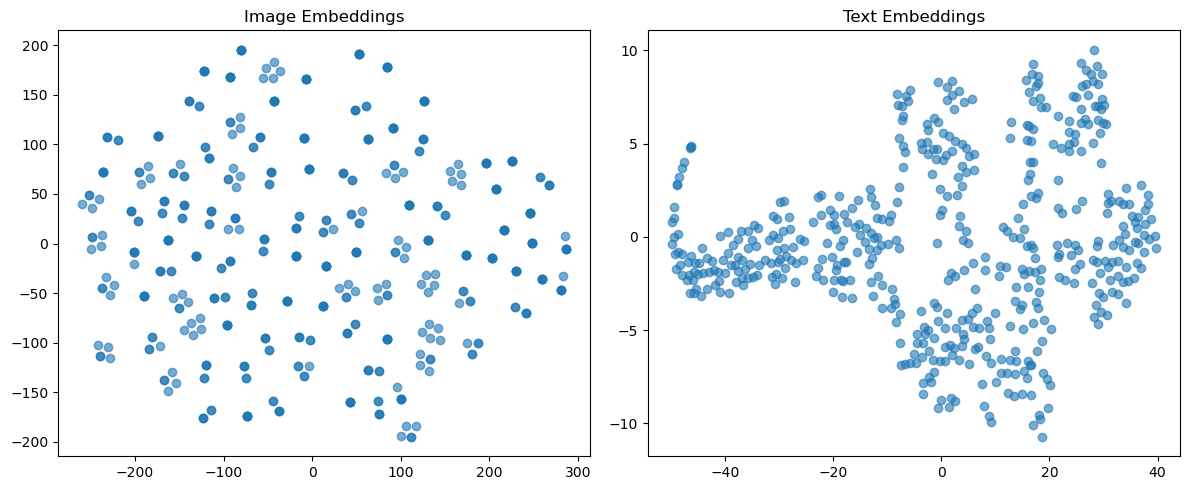


Final Evaluation Results:
Image-to-Text Retrieval:
  Recall@1: 0.0002
  Recall@5: 0.0003
  Recall@10: 0.0008

Text-to-Image Retrieval:
  Recall@1: 0.0000
  Recall@5: 0.0000
  Recall@10: 0.0041

Modality Correlation: 0.0592


In [27]:
if __name__ == "__main__":
    # 1. Model Preparation
    def create_feature_extractor():
        # Context model (Places365)
        model = models.resnet18(num_classes=365)
        checkpoint = torch.load('./places/resnet18_places365.pth.tar', map_location='cpu')
        state_dict = {k.replace('module.', ''): v for k,v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        return nn.Sequential(
            *(list(model.children())[:-2]),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    
    # Evaluate models
    img_ap, text_ap, vad_img, vad_text = test_data(
        [model_context, model_body, flickr_model],
        device,
        test_loader,
        len(test_dataset)
    )
    
    # Initialize models
    model_context = create_feature_extractor().eval()
    model_body = models.resnet18(pretrained=True)
    model_body = nn.Sequential(
        *(list(model_body.children())[:-2]),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    ).eval()

    # Load trained Flickr model
    flickr_model = FlickrSeparateEmbeddings(
        context_features=512,
        body_features=512,
        vocab_size=vocab_size
    )
    flickr_model.load_state_dict(torch.load('./flickr_models/best_model.pth', map_location=device))
    flickr_model = flickr_model.to(device).eval()

    # 2. Modality-Specific Evaluation
    print("\nImage-to-Text Retrieval:")
    img_retrieval = evaluate_modality_retrieval(
        [model_context, model_body, flickr_model],
        device, test_loader, modality='image'
    )
    
    print("\nText-to-Image Retrieval:")
    text_retrieval = evaluate_modality_retrieval(
        [model_context, model_body, flickr_model],
        device, test_loader, modality='text'
    )
    
    # 3. Embedding Analysis
    def analyze_embeddings(models, data_loader):
        model_context, model_body, flickr_model = models
        img_embs = []
        text_embs = []
        
        for context_imgs, body_imgs, captions, _ in data_loader:
            with torch.no_grad():
                context_features = model_context(context_imgs.to(device))
                body_features = model_body(body_imgs.to(device))
                
                _, _, _, img_emb, text_emb = flickr_model(
                    context_features,
                    body_features,
                    captions.to(device)
                )
                
                img_embs.append(img_emb.cpu().numpy())
                text_embs.append(text_emb.cpu().numpy())
        
        return np.concatenate(img_embs), np.concatenate(text_embs)

    img_embs, text_embs = analyze_embeddings(
        [model_context, model_body, flickr_model],
        test_loader
    )
    
    # 4. Statistical Analysis
    print("\nEmbedding Analysis:")
    print(f"Image Embedding Variance: {np.var(img_embs, axis=0).mean():.4f}")
    print(f"Text Embedding Variance: {np.var(text_embs, axis=0).mean():.4f}")
    
    # 5. Visualization
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    # t-SNE visualization
    def plot_tsne(embeddings, title):
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(embeddings[:500])  # Use subset for speed
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
        plt.title(title)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plot_tsne(img_embs, 'Image Embeddings')
    plt.subplot(1, 2, 2)
    plot_tsne(text_embs, 'Text Embeddings')
    plt.tight_layout()
    plt.show()

    # 6. Final Report
    print("\nFinal Evaluation Results:")
    print("Image-to-Text Retrieval:")
    print(f"  Recall@1: {img_retrieval['recall@1']:.4f}")
    print(f"  Recall@5: {img_retrieval['recall@5']:.4f}")
    print(f"  Recall@10: {img_retrieval['recall@10']:.4f}")
    
    print("\nText-to-Image Retrieval:")
    print(f"  Recall@1: {text_retrieval['recall@1']:.4f}")
    print(f"  Recall@5: {text_retrieval['recall@5']:.4f}")
    print(f"  Recall@10: {text_retrieval['recall@10']:.4f}")
    
    print(f"\nModality Correlation: {np.corrcoef(img_embs.mean(1), text_embs.mean(1))[0,1]:.4f}")